In [1]:
# For commands
import os
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
# For array manipulation
import numpy as np
import pandas as pd
import pandas.util.testing as tm
# For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cv2
import imageio as io
from pylab import *
from sklearn.manifold import TSNE
#For model performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import joblib
#For model training
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from PIL import Image

In [2]:
file_path = os.listdir('dataset\img')
print(len(file_path))
train_files, test_files = train_test_split(file_path, test_size = 0.15)
print(len(train_files))
print(len(test_files))

train_files = pd.DataFrame(train_files,columns=['filepath'])
test_files = pd.DataFrame(test_files,columns=['filepath'])
#converting into .csv file for future reference.
train_files.to_csv('train_file.csv')
test_files.to_csv('test_file.csv')

110
93
17


In [3]:
#loading csv files. 
train_files = list(pd.read_csv('train_file.csv')['filepath'])
test_files = list(pd.read_csv('test_file.csv')['filepath'])

dataset\img\img_55.jpg


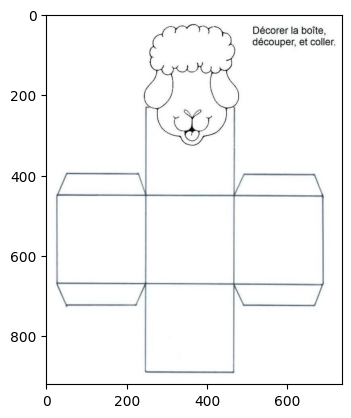

In [4]:
path = 'dataset\\img\\'+ train_files[50]
print(path)
img = io.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [5]:
def image2array(file_array):

    """
    Reading and Converting images into numpy array by taking path of images.
    Arguments:
    file_array - (list) - list of file(path) names
    Returns:
    A numpy array of images. (np.ndarray)
    """

    image_array = []
    for path in tqdm(file_array):
        img = np.array(Image.open("dataset/img/" + path).convert('RGB'))
        # img = cv2.cvtColor(img, cv2.COLOR_)
        img = cv2.resize(img, (224,224))
        img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
        img = 255 - np.array(img)
        kernel = np.ones((2, 2), np.uint8)
        img = cv2.dilate(img, kernel)
        

        # img  = (img > 10) * 255
        image_array.append(np.array(img))
        
    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 1) 
    image_array = image_array.astype('float32')
    image_array /= 255 
    return np.array(image_array)

In [6]:
train_data = image2array(train_files)
print("Length of training dataset:",train_data.shape)
test_data = image2array(test_files)
print("Length of test dataset:",test_data.shape)

  0%|          | 0/93 [00:00<?, ?it/s]

Length of training dataset: (93, 224, 224, 1)


  0%|          | 0/17 [00:00<?, ?it/s]

Length of test dataset: (17, 224, 224, 1)


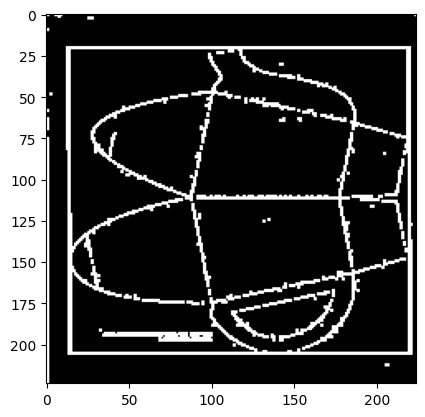

In [8]:
plt.imshow(train_data[20], 'gray')

In [9]:
def encoder_decoder_model():

    """
    Used to build Convolutional Autoencoder model architecture to get compressed image data which is easier to process.
    Returns:
    Auto encoder model
    """
    #Encoder 
    model = Sequential(name='Convolutional_AutoEncoder_Model')
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(224, 224, 1),padding='same', name='Encoding_Conv2D_1'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_1'))
    model.add(Conv2D(128, kernel_size=(3, 3),strides=1,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu',padding='same', name='Encoding_Conv2D_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_3'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid', name='Encoding_MaxPooling2D_4'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv2D_5'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
    
    #Decoder
    model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu', padding='same', name='Decoding_Conv2D_1'))
    model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_1'))
    model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same', name='Decoding_Conv2D_2'))
    model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same',name='Decoding_Conv2D_3'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_3'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_4'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_4'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_5'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_5'))
    model.add(Conv2D(1, kernel_size=(3, 3), padding='same',activation='sigmoid',name='Decoding_Output'))
    return model

In [10]:
def custom_loss(y_true, y_pred):
    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    weighted_loss = tf.where(tf.greater(y_true, y_pred), loss, loss)
    return tf.reduce_mean(weighted_loss)

In [12]:
# the shape without the batch amount
input_shape = train_data.shape[1:]
# how many output neurons we need to create an image
input_dim = np.prod(input_shape)
encoding_dim = 512
model = Sequential([
              Flatten(), # flatten
              Dense(encoding_dim), # encode
              Dense(input_dim), # decode
              Reshape(input_shape) # reshape decoding
])

optimizer = Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='mse') 
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=20,min_delta=0.0001) 
checkpoint = ModelCheckpoint('/content/drive/My Drive/encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 
model.fit(train_data, train_data, epochs=1000, batch_size=8,validation_data=(test_data,test_data),callbacks=[early_stopping,checkpoint]) 

Epoch 1/1000
12/12 [==============================] - 1s 104ms/step - loss: 0.1153 - val_loss: 0.1723
Epoch 2/1000
12/12 [==============================] - 0s 18ms/step - loss: 0.7285 - val_loss: 0.3587
Epoch 3/1000
12/12 [==============================] - 0s 18ms/step - loss: 0.9262 - val_loss: 0.3551
Epoch 4/1000
12/12 [==============================] - 0s 18ms/step - loss: 1.0922 - val_loss: 0.2663
Epoch 5/1000
12/12 [==============================] - 0s 18ms/step - loss: 1.4681 - val_loss: 0.2965
Epoch 6/1000
12/12 [==============================] - 0s 18ms/step - loss: 2.3176 - val_loss: 1.2569
Epoch 7/1000
12/12 [==============================] - 0s 18ms/step - loss: 4.3589 - val_loss: 1.3997
Epoch 8/1000
12/12 [==============================] - 0s 19ms/step - loss: 4.8318 - val_loss: 1.2127
Epoch 9/1000
12/12 [==============================] - 0s 18ms/step - loss: 9.1007 - val_loss: 2.7861
Epoch 10/1000
12/12 [==============================] - 0s 18ms/step - loss: 19.6481 - val_

In [13]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='r'):

    """
    This function is used for plotting images and graphs (Visualization of end results of model training)
    Arguments:
    x - (np.ndarray or list) - an image array
    y1 - (list) - for plotting graph on left side.
    y2 - (list) - for plotting graph on right side.
    row - (int) - row number of subplot
    col - (int) - column number of subplot
    ind - (int) - index number of subplot
    title - (string) - title of the plot 
    xlabel - (list) - labels of x axis
    ylabel - (list) - labels of y axis
    label - (string) - for adding legend in the plot
    isimage - (boolean) - True in case of image else False
    color - (char) - color of the plot (prefered green for training and red for testing).
    """
    
    plt.subplot(row,col,ind)
    if isimage:
        plt.imshow(x)
        plt.title(title)
        plt.axis('off')
    else:
        plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
        if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
        plt.grid()
        plt.legend()
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

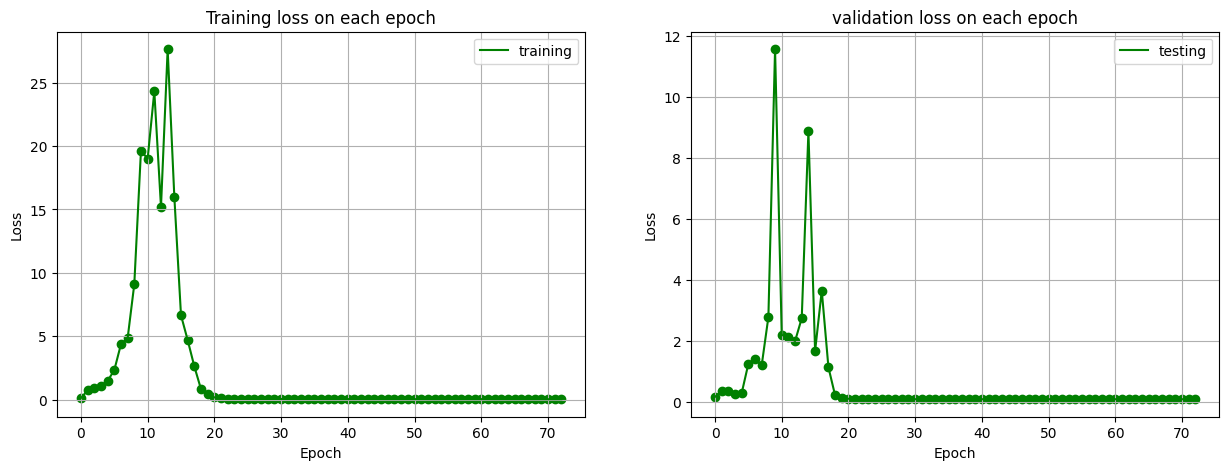

In [14]:
#model.history.history
plt.figure(figsize=(15,5))
epochs = [i for i in range(34)]
plot_(list(range(len(model.history.history["loss"]))),model.history.history["loss"],'',1,2,1,'Training loss on each epoch','Epoch','Loss','training',False,'g')
plot_(list(range(len(model.history.history["loss"]))),model.history.history["val_loss"],'',1,2,2,'validation loss on each epoch','Epoch','Loss','testing',False,'r')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               25690624  
                                                                 
 dense_3 (Dense)             (None, 50176)             25740288  
                                                                 
 reshape_1 (Reshape)         (None, 224, 224, 1)       0         
                                                                 
Total params: 51,430,912
Trainable params: 51,430,912
Non-trainable params: 0
_________________________________________________________________


In [16]:
model = load_model("/content/drive/My Drive/encoder_model.h5")
model.compile(optimizer=optimizer, loss='mse') 

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [196]:
sample_image = train_data[12]
sample_image = np.expand_dims(sample_image,axis=0)
image = model.predict(sample_image)

AttributeError: 'NearestNeighbors' object has no attribute 'predict'

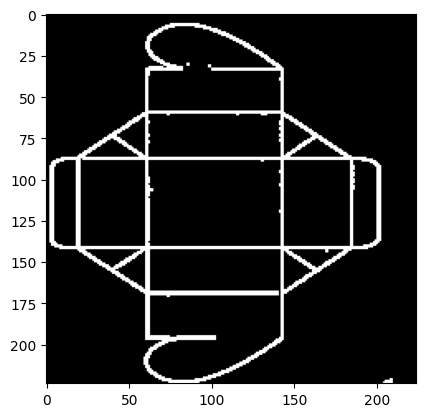

In [18]:
plt.imshow(sample_image[0], 'gray')

In [19]:
sample_image.shape

(1, 224, 224, 1)

In [20]:
image.shape

(1, 224, 224, 1)

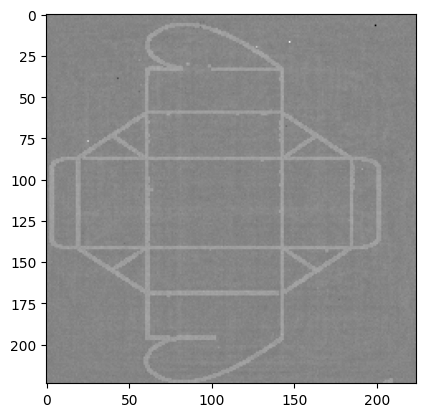

In [21]:
plt.imshow(image[0], 'gray')

In [22]:
image[0].min()

-4.145592

In [23]:
image[0].max()

3.8239417

In [24]:
from keras import backend as K
def feature_extraction(model, data, layer = 1):

    """
    Creating a function to run the initial layers of the encoder model. (to get feature extraction from any layer of the model)
    Arguments:
    model - (Auto encoder model) - Trained model
    data - (np.ndarray) - list of images to get feature extraction from trained model
    layer - (int) - from which layer to take the features(by default = 4)
    Returns:
    pooled_array - (np.ndarray) - array of extracted features of given images
    """

    encoded = K.function([model.layers[0].input],[model.layers[layer].output])
    encoded_array = encoded([data])[0]
    pooled_array = encoded_array.max(axis=-1)
    return encoded_array
encoded = feature_extraction(model,train_data[:10],1)

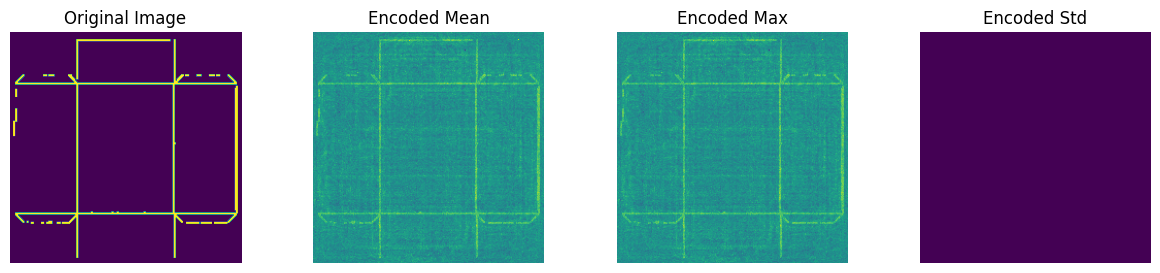

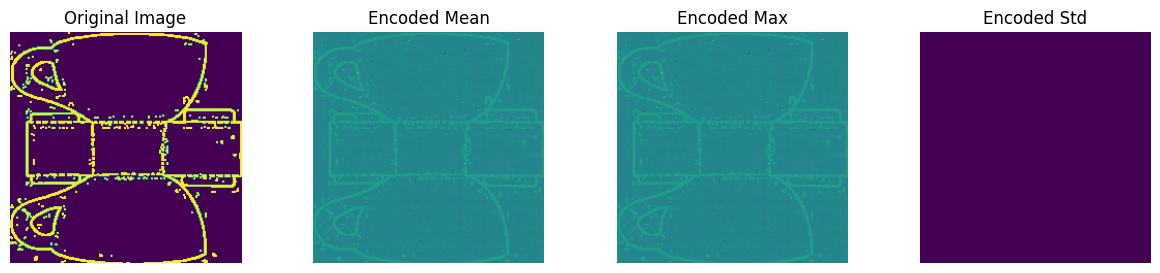

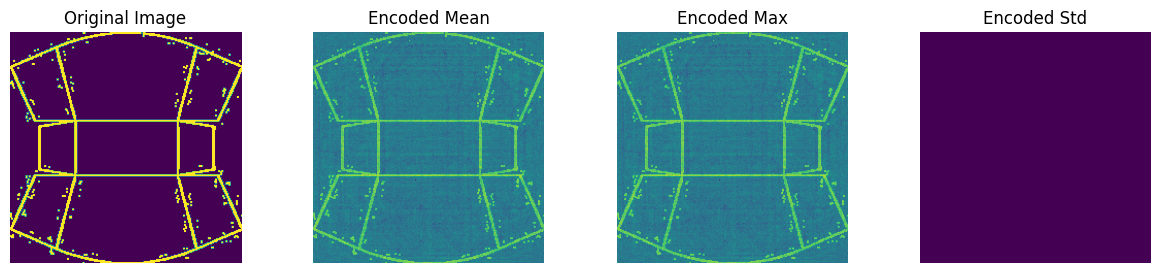

In [25]:
encoded = feature_extraction(model,train_data[:10],3)
for index in [2,6,9]:   # 3 random images
    plt.figure(figsize=(15,3))
    plot_(train_data[index],'','',1,4,1,"Original Image","","",'',True)
    plot_(encoded[index].mean(axis=-1),'','',1,4,2,"Encoded Mean","","",'',True)
    plot_(encoded[index].max(axis=-1),'','',1,4,3,"Encoded Max","","",'',True)
    plot_(encoded[index].std(axis=-1),'','',1,4,4,"Encoded Std","","",'',True)
    plt.show()

In [26]:
def get_batches(data, batch_size=1000):

    """
    Taking batch of images for extraction of images.
    Arguments:
    data - (np.ndarray or list) - list of image array to get extracted features.
    batch_size - (int) - Number of images per each batch
    Returns:
    list - extracted features of each images
    """

    if len(data) < batch_size:
        return [data]
    n_batches = len(data) // batch_size
    
    # If batches fit exactly into the size of df.
    if len(data) % batch_size == 0:
        return [data[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]   

    # If there is a remainder.
    else:
        return [data[i*batch_size:min((i+1)*batch_size, len(data))] for i in range(n_batches+1)]

In [27]:
d = np.concatenate([train_data,test_data],axis=0)
d.shape

(110, 224, 224, 1)

In [28]:
X_encoded = []
i=0
# Iterate through the full training set.
for batch in get_batches(d, 8):
    i+=1
    # This line runs our pooling function on the model for each batch.
    X_encoded.append(feature_extraction(model, batch))
    
X_encoded = np.concatenate(X_encoded)

In [29]:
X_encoded.shape 

(110, 512)

In [30]:
# X_encoded = np.load('/content/drive/My Drive/X_encoded_compressed.npy')
# X_encoded.shape

In [31]:
lisp=train_files
lisp.extend(test_files)
print(len(lisp))

110


In [111]:
#Training the model with optimial K value (6 in our case)
kmeans = KMeans(n_clusters = 20, random_state=0).fit(X_encoded)
labels=kmeans.labels_
centroids = kmeans.cluster_centers_

In [112]:
labels

array([13,  2,  2,  2,  3, 13, 12,  8,  2,  8,  2, 16,  9,  2, 13, 13, 13,
        1,  1, 13,  9,  5, 19, 13,  2,  2,  2, 14, 13,  2, 17,  8, 13,  2,
       13, 13,  1,  2, 11, 13, 13,  8,  8, 14, 13,  2,  8,  9, 10, 19,  1,
        2,  8,  7,  8, 13,  1,  9, 13,  8, 13,  9,  2,  0, 13, 18,  2,  2,
        9,  9,  8,  1,  8, 13,  2,  1,  9, 13, 13, 13,  4,  2,  2,  0,  2,
       13,  8, 13,  6, 15,  2,  9,  2,  2, 13,  8, 13, 13,  8, 13, 13, 13,
       13, 13, 13,  8,  2, 13,  2,  2])

In [48]:
kmeans_file = '/content/drive/My Drive/kmeans_model.pkl'
joblib.dump(kmeans,kmeans_file)

['/content/drive/My Drive/kmeans_model.pkl']

In [113]:
clusters_features = []
cluster_files=[]
for i in list(range(0,20)):
    i_cluster = []
    i_labels=[]
    for iter,j in enumerate(kmeans.labels_):
        if j==i:
            i_cluster.append(X_encoded[iter])
            i_labels.append(lisp[iter])
    i_cluster = np.array(i_cluster)
    clusters_features.append(i_cluster)
    cluster_files.append(i_labels)

In [127]:
cluster_files

[['img_56.jpg', 'img_69.jpg'],
 ['img_8.jpg',
  'img_22.jpg',
  'img_70.jpg',
  'img_55.jpg',
  'img_72.jpg',
  'img_1.jpg',
  'img_47.jpg'],
 ['img_40.jpg',
  'img_100.jpg',
  'img_6.jpg',
  'img_95.jpg',
  'img_21.jpg',
  'img_97.jpg',
  'img_75.jpg',
  'img_105.jpg',
  'img_3.jpg',
  'img_91.jpg',
  'img_5.jpg',
  'img_16.jpg',
  'img_13.jpg',
  'img_103.jpg',
  'img_27.jpg',
  'img_89.jpg',
  'img_36.jpg',
  'img_34.jpg',
  'img_71.jpg',
  'img_98.jpg',
  'img_0.jpg',
  'img_10.jpg',
  'img_86.jpg',
  'img_18.jpg',
  'img_44.jpg',
  'img_26.jpg',
  'img_81.jpg'],
 ['img_61.jpg'],
 ['img_66.jpg'],
 ['img_84.jpg'],
 ['img_83.jpg'],
 ['img_74.jpg'],
 ['img_11.jpg',
  'img_76.jpg',
  'img_20.jpg',
  'img_106.jpg',
  'img_85.jpg',
  'img_12.jpg',
  'img_17.jpg',
  'img_23.jpg',
  'img_24.jpg',
  'img_33.jpg',
  'img_79.jpg',
  'img_49.jpg',
  'img_59.jpg',
  'img_32.jpg',
  'img_37.jpg'],
 ['img_15.jpg',
  'img_87.jpg',
  'img_80.jpg',
  'img_14.jpg',
  'img_52.jpg',
  'img_96.jpg',
  '

In [128]:
labels=[]
data=[]
files=[]
for iter,i in enumerate(clusters_features):
    data.extend(i)
    labels.extend([iter for i in range(i.shape[0])])
    files.extend(cluster_files[iter])
print(np.array(labels).shape)
print(np.array(data).shape)
print(np.array(files).shape)

(110,)
(110, 512)
(110,)


In [190]:
knn = KNeighborsClassifier(n_neighbors=20,algorithm='ball_tree',n_jobs=-1)
knn.fit(np.array(data),np.array(labels))

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=20)

In [191]:
knn_file = '/content/drive/My Drive/knn_model.pkl'
joblib.dump(knn,knn_file)

['/content/drive/My Drive/knn_model.pkl']

In [192]:

def results_(query,result, distance):
    
    """
    Plotting the N similar images from the dataset with query image.
    Arguments:
    query - (string) - filename of the query image
    result - (list) - filenames of similar images
    """

    def read(img):
        image = np.array(Image.open("dataset\\img\\" + img).convert('L'))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        return image
    plt.figure(figsize=(5,3))
    if type(query)!=type(30):
        plot_(query,"","",1,1,1,"Query Image","","","",True, 'gray')
    else:
        plot_(train_data[query],"","",1,1,1,"Query Image "+files[query],"","","",True)
    plt.show()
    plt.figure(figsize=(10,3))
    for iter,i in enumerate(result):
        print(f"{files[i]} have score: {distance[iter]}")
        plot_(read(files[i]),"","",1,len(result),iter+1,files[i],"","","",True)
    plt.show()

In [193]:
len(X_encoded)

110

In [194]:
len(data)

110

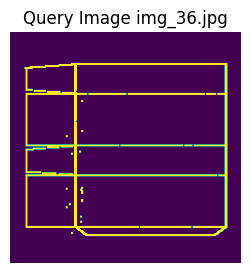

img_71.jpg have score: 97.17004716690978
img_2.jpg have score: 99.82027319431153
img_18.jpg have score: 100.32951072578535
img_68.jpg have score: 100.7949336217391
img_26.jpg have score: 102.29179417107383
img_81.jpg have score: 103.1628373449908
img_0.jpg have score: 104.19945896912681


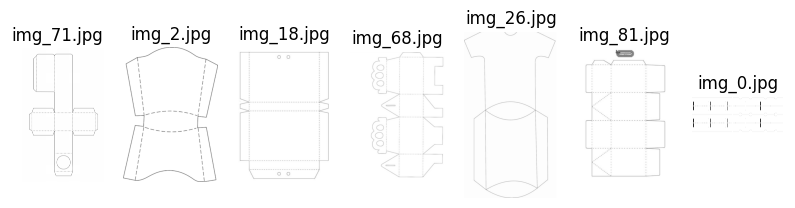

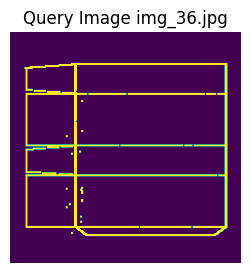

img_67.jpg have score: 0.17733019590377808
img_31.jpg have score: 0.30468982458114624
img_53.jpg have score: 0.3324613571166992
img_94.jpg have score: 0.35305702686309814
img_82.jpg have score: 0.35974597930908203
img_103.jpg have score: 0.37282276153564453
img_101.jpg have score: 0.38254058361053467


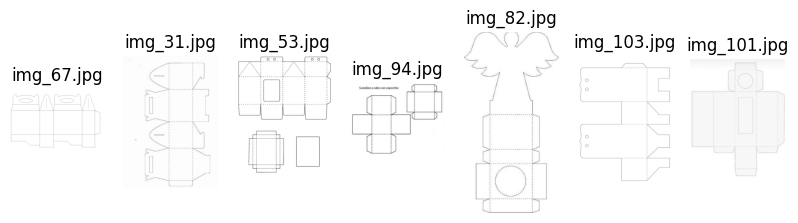

In [195]:
num = 25 #datapoint

res = knn.kneighbors(X_encoded[num].reshape(1,-1),return_distance=True,n_neighbors=8)
results_(num,list(res[1][0])[1:], res[0][0][1:])

res = model.kneighbors(X_encoded[num].reshape(1,-1),return_distance=True,n_neighbors=8)
results_(num,list(res[1][0])[1:], res[0][0][1:])

In [157]:
# from scipy import spatial

In [147]:
# tree = spatial.KDTree(X_encoded)

In [149]:
res

(0.0, 90)

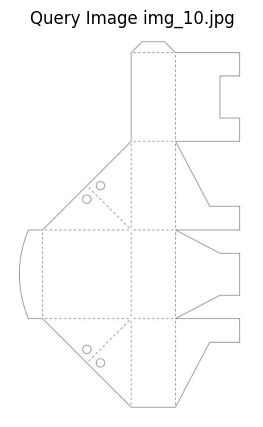

img_93.jpg have score: 0.0


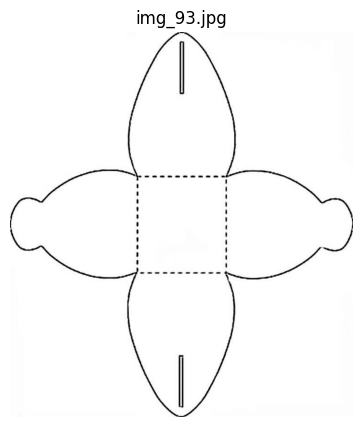

In [150]:
results_(num,[res[1]], [res[0]])

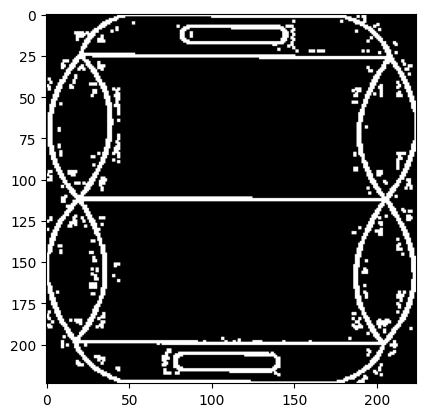

In [87]:
plt.imshow(train_data[83], 'gray')

In [160]:
from sklearn.neighbors import NearestNeighbors

In [161]:
model = NearestNeighbors(n_neighbors=2,
                         metric='cosine',
                         algorithm='brute',
                         n_jobs=-1)
model.fit(X_encoded)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=2)

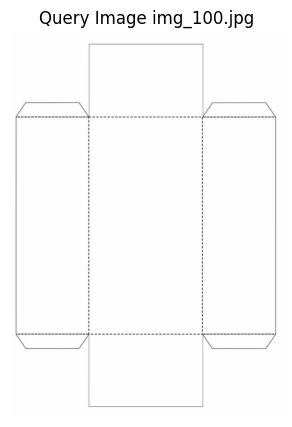

img_79.jpg have score: 0.32104241847991943
img_11.jpg have score: 0.39162760972976685
img_85.jpg have score: 0.39428067207336426
img_13.jpg have score: 0.41573143005371094
img_102.jpg have score: 0.41634321212768555
img_42.jpg have score: 0.4211122989654541
img_16.jpg have score: 0.4284122586250305


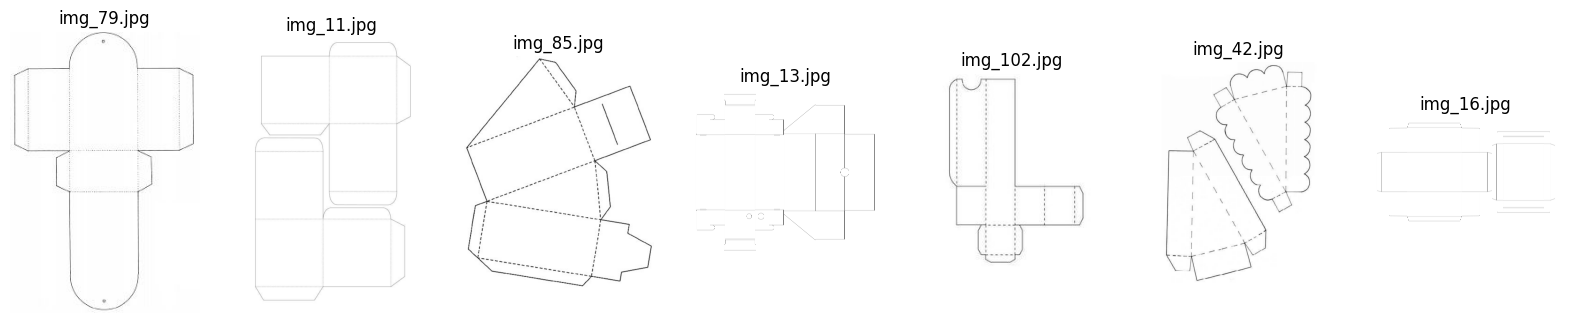

In [165]:
num= 10
res = model.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=8)
results_(num,list(res[1][0])[1:], res[0][0][1:])
